# Exploring DSC SET Data

In [189]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical and machine learning libraries
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr, spearmanr
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score, mean_squared_error, r2_score
)
from sklearn.inspection import permutation_importance

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Step 1: Data Cleaning and Feature Engineering

We need to:
1. Extract course numbers from course titles
2. Standardize term formats
3. Clean and extract numeric values from grade fields

*Load and clean SETs Data*

In [180]:
# load sets into dataframe
dsc_sets = pd.read_csv('datasets/dsc_sets.csv')

# merge duplicate columns
dsc_sets["Enrolled Resp Rate"] = dsc_sets["Enrolled/ Resp Rate"].fillna(dsc_sets["Enrolled/  Resp Rate"])
dsc_sets = dsc_sets.drop(columns=["Enrolled/ Resp Rate", "Enrolled/  Resp Rate"])

# rename columns for easier access
dsc_sets.columns = dsc_sets.columns.str.replace('*', '', regex=False)
dsc_sets.columns = dsc_sets.columns.str.replace(' ', '_')
dsc_sets['Term'] = dsc_sets['Term'].str.lower()


# Extract the number before the parentheses
dsc_sets['Enrolled_Resp_Number'] = dsc_sets['Enrolled_Resp_Rate'].str.extract(r'(\d+)\s*\(')[0].astype(int)
# Extract the percentage inside parentheses
dsc_sets['Enrolled_Resp_Pct'] = dsc_sets['Enrolled_Resp_Rate'].str.extract(r'\(([\d\.]+)%\)')[0].astype(float)

# remove Letter from Avg Grade Received
dsc_sets["Avg_Grade_Received"] = (
    dsc_sets["Avg_Grade_Received"]
    .str.extract(r'(\d+\.\d+|\d+)')   # extract first number
    .astype(float)
)

# delete unnecessary columns
dsc_sets = dsc_sets.drop(columns=["Course", "Enrolled_Resp_Rate"])
# remove dsc96 course (doesn't have grades)
dsc_sets = dsc_sets[dsc_sets['course_title'] != 'dsc95']

dsc_sets = dsc_sets.dropna(subset=['Avg_Grade_Received'])
dsc_sets.head()

,Instructor,Term,Avg_Grade_Received,Avg_Hours_Worked,Learning_Average,Structure_Average,Environment_Average,course_title,Enrolled_Resp_Number,Enrolled_Resp_Pct
0,"Bellur, Umesh",wi25,3.93,9.93,3.74,3.55,4.12,dsc180b,114,14.04
1,"Bellur, Umesh",wi25,3.99,11.89,4.02,3.74,3.80,dsc180b,118,16.95
2,"Rampure, Suraj",wi24,3.96,9.60,4.60,4.59,4.58,dsc180b,97,10.31
3,"Rampure, Suraj",wi24,3.99,6.23,4.57,4.57,4.53,dsc180b,138,9.42
4,"Weng, Tsui-Wei (lily)",sp25,3.71,7.38,4.19,4.13,4.24,dsc140b,124,45.16


*Merge SETs data with Utilization Rate from WebReg Data*

In [181]:
webreg_data = pd.read_csv('webreg_data/results/webreg_processed_data.csv')
webreg_data.head()
merged_data = webreg_data[['course', 'quarter', 'utilization_rate']]
merged_data = merged_data.copy()

#drop underscore from course column to match dsc_sets
merged_data['course'] = merged_data['course'].str.replace('_', '').str.lower()
merged_data = merged_data.rename(columns={'course': 'course_title', 'quarter': 'Term'})
# merge datasets on course title and term
final_data = pd.merge(dsc_sets, merged_data, on=['course_title', 'Term'], how='inner')
cols = ['course_title'] + [c for c in final_data.columns if c != 'course_title']
final_data = final_data[cols]

final_data.head()

,course_title,Instructor,Term,Avg_Grade_Received,Avg_Hours_Worked,Learning_Average,Structure_Average,Environment_Average,Enrolled_Resp_Number,Enrolled_Resp_Pct,utilization_rate
0,dsc180b,"Bellur, Umesh",wi25,3.93,9.93,3.74,3.55,4.12,114,14.04,98.30
1,dsc180b,"Bellur, Umesh",wi25,3.99,11.89,4.02,3.74,3.80,118,16.95,98.30
2,dsc140b,"Weng, Tsui-Wei (lily)",sp25,3.71,7.38,4.19,4.13,4.24,124,45.16,97.62
3,dsc140b,"Huang, Biwei",wi25,3.53,6.38,4.25,4.27,4.57,42,30.95,29.66
4,dsc100,"Salimi, Babak",sp25,3.63,5.44,4.04,3.61,4.05,139,74.10,92.47


## Step 2: EDA of SETs + Utilization Data

We set to explore our data with these hypotheses in mind.  
* **Initial Null Hypothesis**: None of the numeric course metrics are linearly related to seat utilization.  
* **Alternative Hypothesis**: At least one numeric predictor has a non-zero linear effect on seat utilization.


In [182]:
numeric_cols = ['Avg_Grade_Received', 'Avg_Hours_Worked',
                'Learning_Average', 'Structure_Average', 
                'Environment_Average',
                'Enrolled_Resp_Pct']
numeric_df = final_data[numeric_cols]

### Graph 1: Correlation of Numeric Course Metrics
This visualization shows the pairwise linear correlations among key numeric course metrics in the dataset, focusing on the lower triangle of the correlation matrix to avoid redundancy.

The variables included are:
* Avg_Grade_Received – average grade students earned in the course
* Avg_Hours_Worked – average weekly hours students reported spending on the course
* Learning_Average – students’ evaluation of how much they learned
* Structure_Average – students’ evaluation of the course’s organization and clarity
* Environment_Average – students’ evaluation of the classroom and learning environment
* Enrolled_Resp_Pct – enrollment/response percentage

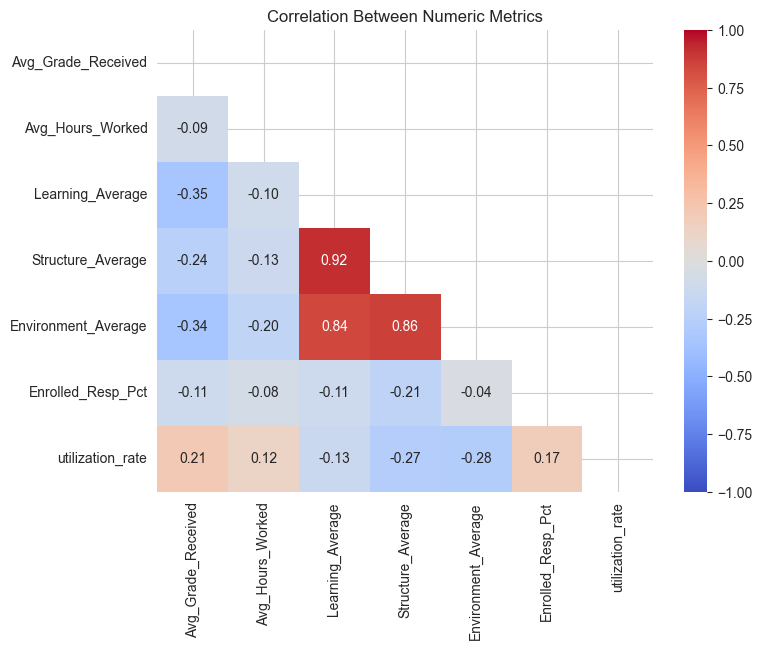

In [218]:
numeric_cols2 = ['Avg_Grade_Received', 'Avg_Hours_Worked',
                'Learning_Average', 'Structure_Average', 
                'Environment_Average',
                'Enrolled_Resp_Pct', 'utilization_rate']

corr = final_data[numeric_cols2].corr()
plt.figure(figsize=(8,6))  # set figure size
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    annot=True,       # show correlation values
    fmt=".2f",        # format numbers
    cmap='coolwarm',  # color map
    vmin=-1, vmax=1,   # fix color scale
    mask=mask      # hide diagonal
)
plt.title("Correlation Between Numeric Metrics")
plt.show()

`Structure_Average`, `Learning_Average`, and `Environment_Average` exhibit strong positive correlations, indicating consistent student perceptions across these aspects, this also is a potential indicator of multi-colinearity. `utilization_rate` on the other hand doesn't have a very strong correlation with any variable, meaning that attempts to find linear correlations with the variables that we have may be weak.

### Test 1: Test for Multi-Colinearity

**Purpose**: Determine if numeric predictors are highly correlated with each other, which can inflate regression coefficients and make them unstable.

**Testing**: 
* **Variance Inflation Factor**: Quantitative measure of multicollinearity.
    * **VIF > 5**: Moderate multicollinearity
    * **VIF > 10**: High multicollinearity



In [212]:
X = numeric_df.dropna() 
X = sm.add_constant(X) 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data 

,feature,VIF
0,const,899.199039
1,Avg_Grade_Received,1.289189
2,Avg_Hours_Worked,1.092279
3,Learning_Average,7.520313
4,Structure_Average,9.491311
5,Environment_Average,4.794431
6,Enrolled_Resp_Pct,1.178673


**Interpretation**: 
* Predictors with high VIF such as `Learning_Average` = 7.52 and `Structure_Average` = 9.54 are strongly correlated can inflate regression coefficients for our linear regression model.
* Predictors with low VIF (< 5) are unlikely to cause multicolinearity issues



### Graph 2: Distribution of Utilization Rate
Visualize how `utilization_rate` is distributed across courses. This helps identify whether most courses are near full capacity, underenrolled, or evenly spread.

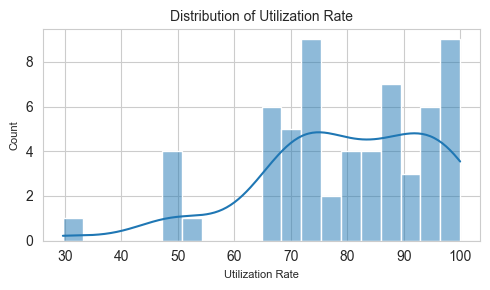

In [219]:
plt.figure(figsize=(5, 3))
sns.histplot(final_data['utilization_rate'], bins=20, kde=True)
plt.title("Distribution of Utilization Rate", fontsize=10)
plt.xlabel("Utilization Rate", fontsize=8)
plt.ylabel("Count", fontsize=8)
plt.tight_layout()
plt.show()

### Test 2: Simple Linear Regression of Numeric Predictors on Utilization Rate

**Purpose**: Find if any numeric variables predict `utilization_rate` in a univariate model.

**Testing**: 
* **Coefficient**: Change in `utilization_rate` for a one-unit increase in predictor.
* **p-value**: If predictor's effect is significantly associated with `utilization_rate` (is if \< 0.05)
* **$R^2$**: Proportion of variance in `utilization_rate` explained by the predictor alone.


In [214]:
results = []

for col in numeric_cols:
    X = final_data[[col]]
    Y = final_data['utilization_rate']
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(Y, X).fit()
    
    # Save results
    results.append({
        'Predictor': col,
        'Coefficient': model.params[col],
        'Intercept': model.params['const'],
        'R_squared': model.rsquared,
        'p_value': model.pvalues[col]
    })

# Convert to DataFrame for easy viewing
regression_results = pd.DataFrame(results)
print(regression_results)

             Predictor  Coefficient   Intercept  R_squared   p_value
0   Avg_Grade_Received     8.721208   50.218312   0.045302  0.099580
1     Avg_Hours_Worked     0.986878   72.213639   0.014111  0.361866
2     Learning_Average    -6.445470  107.707438   0.018090  0.301401
3    Structure_Average   -11.990614  130.222766   0.070799  0.038201
4  Environment_Average   -17.965713  159.984205   0.077289  0.030055
5    Enrolled_Resp_Pct     0.117170   74.025213   0.030149  0.180810


**Interpretation**: 
* \+ coefficient → Higher predictor values are associated with higher utilization.
* \- coefficient → Higher predictor values are associated with lower utilization.
* Significant p-value (<0.05) → Predictor reliably explains changes in utilization rate.
* $R^2$ indicates how much of the variation in utilization is captured by this single predictor.


### Test 3: Standard Multiple Linear-Regression

**Purpose**: Assess how multiple numeric variables collectively predict `utilization_rate` and identify which predictors remain significant after accounting for others. 

**Testing**: 
* **Coefficient**: Change in `utilization_rate` for a one-unit increase in predictor.
* **Standard Error**: Measures  variability of the coefficient estimate; smaller values = more precise estimates.
* **p-value**: If predictor's effect is significantly associated with `utilization_rate` (is if \< 0.05)

In [215]:
X = numeric_df.copy()  # predictors
y = final_data['utilization_rate']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Add constant for statsmodels
X_train_scaled_df = sm.add_constant(X_train_scaled_df)
X_test_scaled_df = sm.add_constant(X_test_scaled_df)

# Fit model
model = sm.OLS(y_train.values, X_train_scaled_df)  # use .values to ignore index mismatch
results = model.fit()

coef_table = results.summary2().tables[1][['Coef.', 'Std.Err.', 'P>|t|']]
coef_table = coef_table.rename(columns={
    'Coef.': 'Coefficient',
    'Std.Err.': 'Std_Error',
    'P>|t|': 'p_value'
})

coef_table.round(3)

,Coefficient,Std_Error,p_value
const,80.027,2.102,0.000
Avg_Grade_Received,2.599,2.375,0.280
Avg_Hours_Worked,1.668,2.170,0.447
Learning_Average,11.342,5.346,0.040
Structure_Average,-5.249,6.425,0.419
Environment_Average,-8.601,4.598,0.069
Enrolled_Resp_Pct,3.917,2.325,0.100


**Interpretation**: 
* We have a lot of variables with high p-values, this could be due to a multitude of reasons, such as multicolinearity, or the variables not being significantly associated with `utilization_rate` 

### Graph 3: Residual Distribution Plot
Here we plot the Residuals for the above Multivariate-Linear Model 

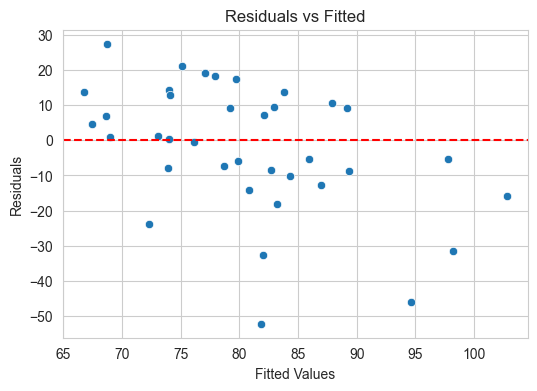

In [216]:
y_train_pred = results.predict(X_train_scaled_df)

# Compute residuals
residuals = y_train - y_train_pred

# ---- Residuals vs Fitted ----
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_train_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

### Test 4: Multiple Linear-Regression w/ Backward Elimination

**Purpose**: Backward elimination removes variables with the least statistical contribution iteratively. Since most of our variables have high p-values, then we are going to remove variables that are irrelevant to the model.

**Testing**: 
* **Mean Squared Error (MSE)**: Squared difference between predicted and actual `utilization_rate` in the test set; smaller values indicate better predictive accuracy.
* **$R^2$ (Test Set)**: Proportion of variance in `utilization_rate` explained by model on test set; ranges from 0 to 1.

In [217]:
# 1. Define predictors and target
X = numeric_df.copy() 
y = final_data['utilization_rate']

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Standardize features
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 4. Add constant for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# 5. Backward elimination function
def backward_elimination(X, y, sl=0.05, verbose=True):
    X_model = X.copy()
    while True:
        model = sm.OLS(y, X_model).fit()
        pvalues = model.pvalues.drop('const')  # ignore intercept
        max_pval = pvalues.max()
        
        if max_pval > sl:
            drop_col = pvalues.idxmax()
            if verbose:
                print(f"Dropped '{drop_col}' with p-value {max_pval:.3f}")
            X_model = X_model.drop(columns=[drop_col])
        else:
            break
    return model


# 6. Run backward elimination
X_train_scaled = X_train_scaled.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
final_model = backward_elimination(X_train_scaled, y_train)

# 7. Prepare test set with final predictors
X_test_selected = X_test_scaled[final_model.model.exog_names]

# 8. Predict on test set
y_pred = final_model.predict(X_test_selected)

# 9. Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final test set MSE:", round(mse, 3))
print("Final test set R^2:", round(r2, 3))

# 10. Print value values
coef_table = pd.DataFrame({
    'Coefficient': final_model.params,
    'Std_Error': final_model.bse,
    'p_value': final_model.pvalues
}).round(3)

coef_table

Dropped 'Avg_Hours_Worked' with p-value 0.447
Dropped 'Structure_Average' with p-value 0.448
Dropped 'Avg_Grade_Received' with p-value 0.412
Dropped 'Enrolled_Resp_Pct' with p-value 0.051
Dropped 'Learning_Average' with p-value 0.065
Final test set MSE: 210.357
Final test set R^2: -0.043


,Coefficient,Std_Error,p_value
const,80.027,2.202,0.00
Environment_Average,-4.920,2.202,0.03


**Interpretation**: 
* Test Set MSE = 210.357 → The model’s predictions deviate from actual values by an average squared error of ~210.
* Test Set R² = -0.043 → The model does not explain variability in `utilization_rate` on the test set; in fact, it performs worse than predicting the mean.
* Our model has poor predictive power, suggesting that numeric course metrics alone do not reliably predict utilization rate.
